*Technical University of Munich<br>
Professorship of Environmental Sensing and Modeling<br><br>*
**Author:**  Daniel Kühbacher<br>
**Date:**  03.09.2024

--- 

# Calculate Motorway CO emissions at different speed limits

<!--Notebook description and usage information-->
This notebook implements the <utls/hot_emission_process.py> function and multiprocessing to calculate hot vehicle emissions for a given area. 


In [1]:
# import libraries
import sys
import os
os.environ['USE_PYGEOS'] = '0'

import multiprocessing
import geopandas as gpd
import pandas as pd
from datetime import datetime

sys.path.append('../../utils')
import data_paths
from traffic_counts import TrafficCounts
from hbefa_hot_emissions import HbefaHotEmissions
from hot_emission_process import process_daily_emissions, process_hourly_emissions

# Reload local modules on changes
%reload_ext autoreload
%autoreload 2

# Notebook Settings

In [2]:
# Define start and end time for emission calculation. Ideally this should cover a whole year.
year = 2019
start_date = datetime(year, 1, 1)
end_date = datetime(year, 12, 31)

# define filename of the visum file
visum_filename = "visum_links.GPKG"

# if True, the script will only calculate the emission for the area within the roi polygon
clip_to_area = True
roi_polygon = data_paths.MUNICH_BOARDERS_FILE # defines ROI for clipping

# select aggregated or los-specific mode for traffic situation calculation
mode = 'aggregated' 
#mode = 'los_specific'

vehicle_classes = ['PC', 'LCV', 'HGV', 'BUS', 'MOT']
components = ['HC', 'CO', 'NOx', 'PM', 'PN', 'CO2(rep)',
              'CO2(total)', 'NO2', 'CH4', 'NMHC', 'PM (non-exhaust)', 'Benzene', 'PM2.5',
              'BC (exhaust)', 'PM2.5 (non-exhaust)', 'BC (non-exhaust)', 'CO2e']

components = ['CO', 'CO2(total)']

# Choose emission type: Tank-To-Wheel, Well-To-Tank (WTT), Well-To-Wheel (WTW)
# WTW includes upstream emisssions from fuel production and distribution
emission_type = 'EFA_weighted'
#emission_type = 'EFA_WTT_weighted'
#emission_type = 'EFA_WTW_weighted'

# if True, the timeprofiles for the selected components will be calculated
calculate_timeprofile = False
store_timeprofiles = False

# define number of processes for multiprocessing
NUMBER_OF_PROCESSES = 7

###
#
# STORE RESULTS
#
###

store_results = False
store_filename = f'linesource_Munich_{year}_los_specific.gpkg'

## Import Data and Initialize Objects

In [3]:
# import visum model
visum_raw = gpd.read_file(data_paths.VISUM_FOLDER_PATH + visum_filename)

if clip_to_area:
    roi = gpd.read_file(roi_polygon).to_crs(visum_raw.crs)
    visum = gpd.clip(visum_raw, roi)
    visum = visum.explode(ignore_index=True) # convert multipolygons to polygons

#visum = visum_links
visum = visum.reset_index(drop = True).reset_index() # reset index for calculation

# initialize traffic cycles
cycles = TrafficCounts()

In [4]:
#visum = visum_raw.copy()

# change speed in VISUM model
#visum.loc[visum['road_type'].isin(['Motorway-Nat']) & (visum['hbefa_speed'] == 120), 'hbefa_speed'] = '>130'

# subselect only motorway road links
#visum = visum[visum['road_type'].isin(['Motorway-Nat'])]

# initialize specific HBEFA emission factors
hbefa = HbefaHotEmissions(components= components, 
                          vehicle_classes= vehicle_classes, 
                          ef_type= emission_type, 
                          area_type= 'Urban')

Loaded emission factors from /Users/daniel_tum/Documents/code/drive-inventory/data/restricted_input/hbefa/EFA_HOT_ts_hbefa.txt
Loaded emission factors from /Users/daniel_tum/Documents/code/drive-inventory/data/restricted_input/hbefa/EFA_HOT_aggregated_hbefa.txt


## Process Inventory
Use multiprocessing to calculate the emission for each road link day by day. This process will take some time to be finished for the whole area of interest.

In [5]:
# calculate emission for each day
dates = [d.strftime("%Y-%m-%d") for d in pd.date_range(start = start_date,
                                                       end = end_date,
                                                       freq = '1d')]

with multiprocessing.Manager() as manager: 
    
    result_queue = manager.Queue()
    error_queue = manager.Queue()
    
    with multiprocessing.Pool(NUMBER_OF_PROCESSES) as pool:
        parameters = [(d,
                       mode,
                       visum.to_dict('records'),cycles,
                       hbefa,
                       result_queue,
                       error_queue,
                       ) for d in dates]
        
        res = pool.starmap(process_daily_emissions, parameters)
    
    # concatenate final process results.
    result = result_queue.get() #get first result from queue
    while not result_queue.empty():
        print('Concatenate final process results')
        new_result = result_queue.get()
        for road_index, emissions in result.items():
            for component, value in emissions.items():
                add_emissions = new_result[road_index][component]
                result[road_index][component] += add_emissions
                
    # retrieve process errors
    errors = list()
    while not error_queue.empty(): 
        errors.append(error_queue.get())

Finished calculating 2019-01-01
Finished calculating 2019-01-15
Finished calculating 2019-01-02
Finished calculating 2019-01-29
Finished calculating 2019-01-16
Finished calculating 2019-02-12
Finished calculating 2019-01-03
Finished calculating 2019-01-30
Finished calculating 2019-02-26
Finished calculating 2019-01-17
Finished calculating 2019-02-13
Finished calculating 2019-03-12
Finished calculating 2019-01-31
Finished calculating 2019-01-04
Finished calculating 2019-02-27
Finished calculating 2019-03-26
Finished calculating 2019-01-18
Finished calculating 2019-02-14
Finished calculating 2019-03-13
Finished calculating 2019-01-05
Finished calculating 2019-02-28
Finished calculating 2019-02-01
Finished calculating 2019-03-27
Finished calculating 2019-03-14
Finished calculating 2019-02-15
Finished calculating 2019-01-19
Finished calculating 2019-02-02
Finished calculating 2019-03-01
Finished calculating 2019-03-28
Finished calculating 2019-01-06
Finished calculating 2019-03-15
Finished

In [6]:
# print errors
for e in errors:
    print (e)

## Concatenate Results
All results are saved in result dict. This can be appended to the traffic model. 

In [11]:
# concatenate results and append to visum dataframe

result_df = pd.DataFrame(result).transpose()
result_df.columns = result_df.columns.map('_'.join)
visum_result = pd.concat([visum, result_df], axis = 1)

## Store results

In [12]:
for c in components:
    cols = [v+'_'+c for v in vehicle_classes]
    visum_result['total_'+c] = visum_result[cols].sum(axis=1)
    visum_result['total_'+c] = visum_result['total_'+c]*visum_result.geometry.length/1000 # convert to g/km


In [13]:
(visum_result.groupby('road_type').sum(numeric_only=True)[['total_CO', 'total_CO2(total)']]*1e-6)['total_CO'].sum()

np.float64(2625.54804148336)

<Axes: >

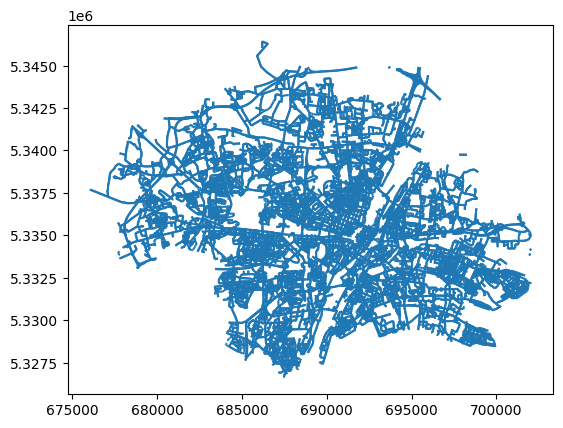

In [14]:
visum_result.plot()